# 08. PyTorch Paper Replicating

## 0. Get setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.86 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

In [3]:
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

In [4]:
import os

train_dir = data_path / "train"
test_dir = data_path / "test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=transform,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [5]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([2, 0, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2,
         0, 1, 2, 1, 0, 1, 1, 0]))

In [6]:
image, label = images[0], labels[0]

(-0.5, 223.5, 223.5, -0.5)

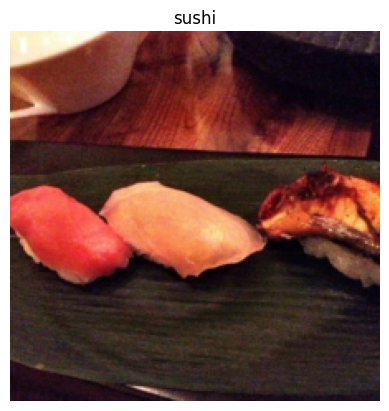

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

## 3. Replicating ViT

## 4. Equation 1: Split data into patches and creating the class, position and path embedding

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of paches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

### 4.1 Calculate input and output shapes by hand

In [8]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))
number_of_patches

196

In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

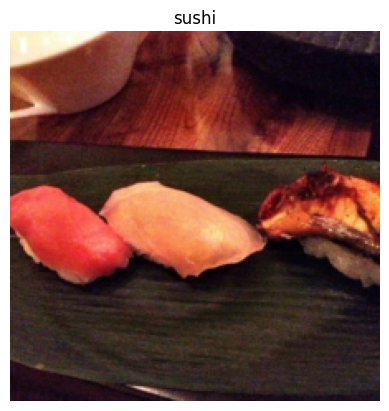

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

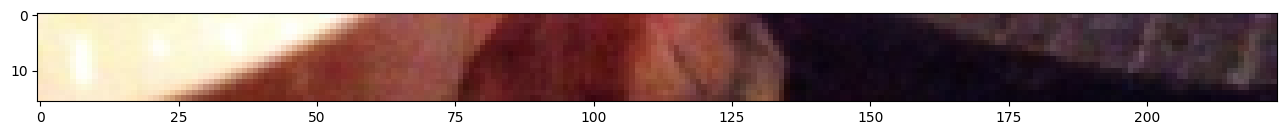

In [11]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

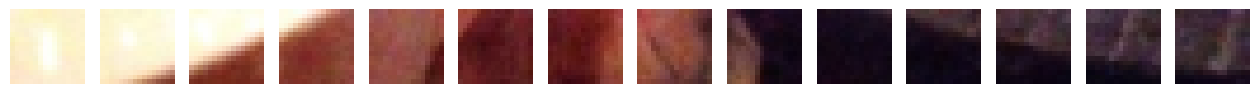

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])
  axis[i].axis("off")

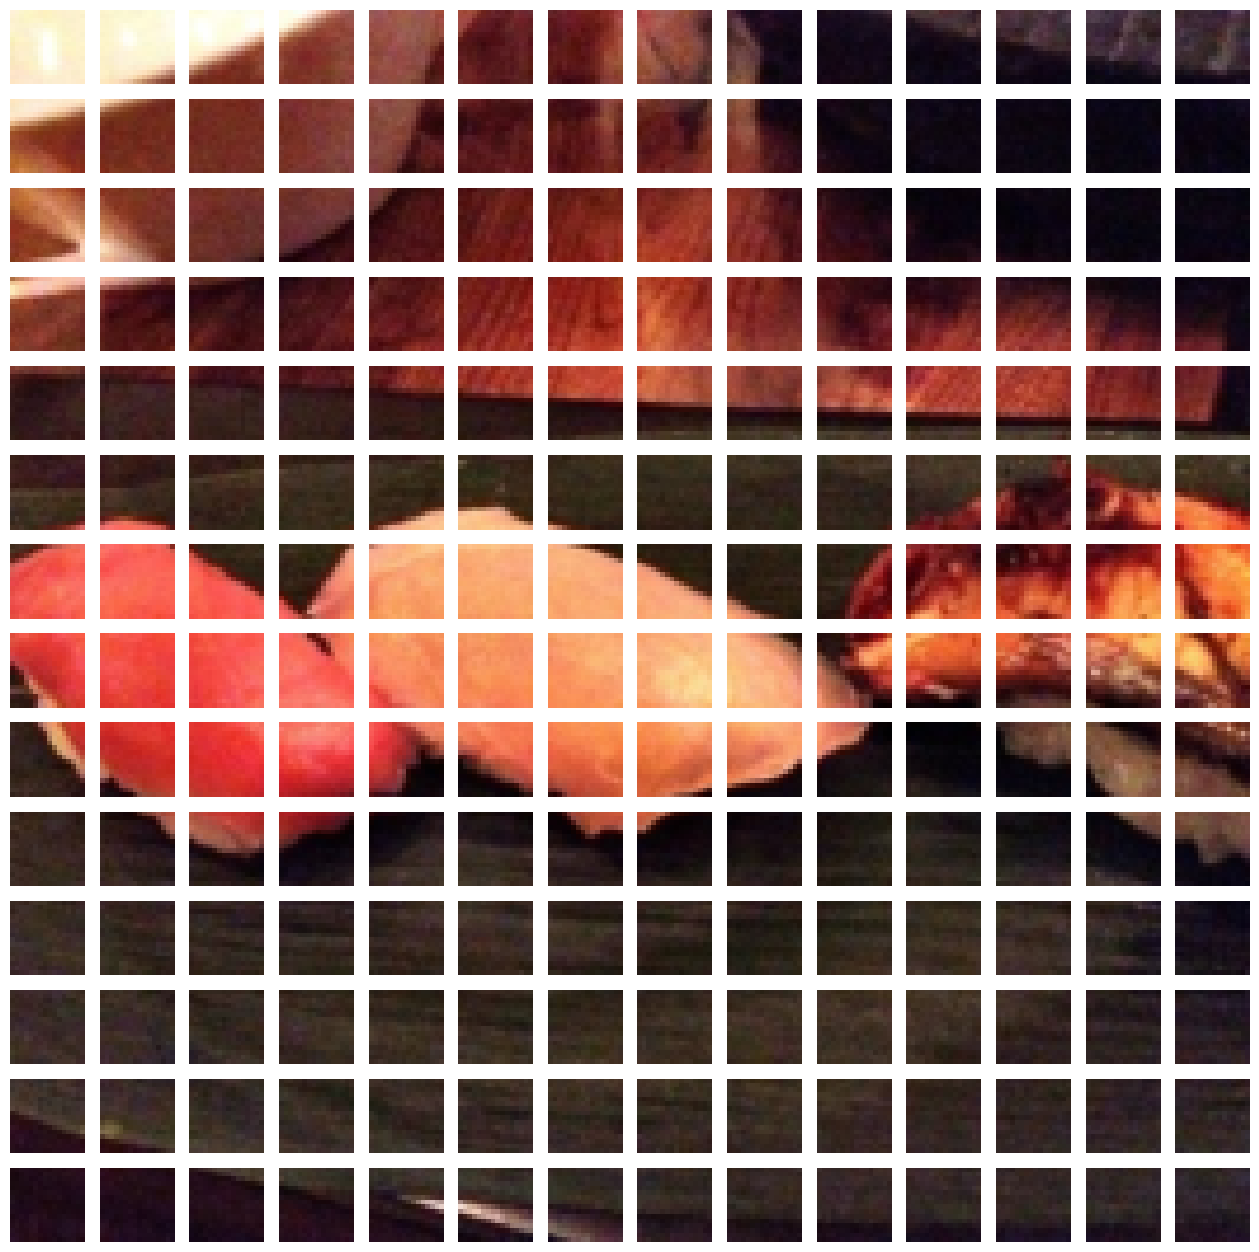

In [13]:
 # Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))

for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axis[i][j].imshow(image_permuted[patch_row:patch_row + patch_size, patch_col:patch_col+patch_size, :])
    axis[i][j].set_xlabel(i+1)
    axis[i][j].set_xticks([])
    axis[i][j].set_yticks([])
    axis[i][j].axis("off")

### 4.3 Creating image patches and turning them into patch embeddings

In [14]:
# Create conv2ddd layer to turn image into patches of learnable feature maps (embedings)
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

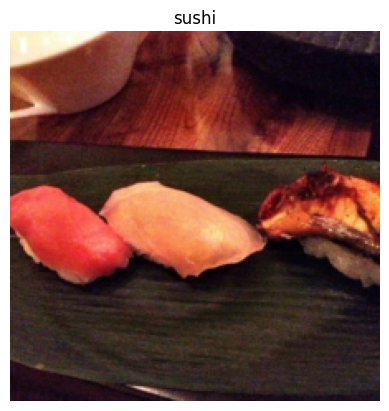

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [16]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Random indexs: [260, 427, 61, 652, 619]


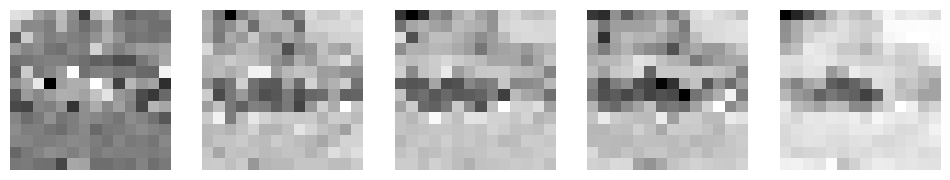

In [17]:
# plot random convolutionla feature maps (embeddings)

import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Random indexs: {random_indexs}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.detach().numpy().squeeze(), cmap=plt.cm.gray)
  axs[i].axis("off")


In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[0.7711, 0.7549, 0.7573, 0.4435, 0.4047, 0.2771, 0.3134, 0.3988,
          0.1495, 0.0955, 0.1269, 0.2081, 0.2193, 0.2304],
         [0.5046, 0.2868, 0.3101, 0.3507, 0.2932, 0.2274, 0.2721, 0.2783,
          0.1832, 0.0801, 0.0693, 0.0717, 0.0651, 0.0611],
         [0.5175, 0.3141, 0.2996, 0.2907, 0.2025, 0.2757, 0.3259, 0.3757,
          0.2766, 0.1399, 0.0794, 0.0627, 0.0554, 0.0705],
         [0.4745, 0.2442, 0.1863, 0.2053, 0.2841, 0.3473, 0.3851, 0.4226,
          0.3330, 0.2376, 0.2369, 0.2655, 0.1573, 0.1156],
         [0.1855, 0.1965, 0.1939, 0.2004, 0.2479, 0.2590, 0.3183, 0.4116,
          0.3212, 0.4296, 0.4148, 0.3676, 0.2912, 0.1907],
         [0.2498, 0.2004, 0.1626, 0.1779, 0.1908, 0.1948, 0.1958, 0.1557,
          0.1464, 0.1606, 0.1887, 0.2090, 0.3303, 0.2708],
         [0.5982, 0.7039, 0.3522, 0.3868, 0.7052, 0.6728, 0.6103, 0.2543,
          0.1244, 0.2253, 0.3873, 0.3409, 0.4618, 0.6639],
         [0.5674, 0.6364, 0.6853, 0.5684, 0.6874, 0.6721, 0.6743, 0.6

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [19]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
image_out_of_flat = flatten_layer(image_out_of_conv)
image_out_of_flat.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [20]:
single_flattened_feature_map = image_out_of_flat.permute(0, 2, 1)[:, :, 0]

# Plot the flattenend feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis("off")

(-0.5, 195.5, 0.5, -0.5)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [21]:
input_layer = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),

    nn.Flatten(start_dim=2, end_dim=-1)
)

In [22]:
out_image = input_layer(image.unsqueeze(dim=0))
out_image.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, "Image size must be divisible by patch size"
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)

In [24]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image.shape, image.unsqueeze(dim=0).shape

(torch.Size([1, 196, 768]), torch.Size([1, 3, 224, 224]))

### 4.6 Creatign the class token embedding

In [25]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [26]:
# Create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
# Add the class token embeding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9749,  0.2335, -0.2732,  ...,  0.7198, -0.4522,  0.3564],
          [-0.8964,  0.2239, -0.1626,  ...,  0.7135, -0.5242,  0.3641],
          ...,
          [-0.1660,  0.0230, -0.0521,  ...,  0.1051, -0.0819,  0.0440],
          [-0.1983,  0.0407, -0.0356,  ...,  0.0992, -0.0575,  0.0372],
          [-0.1757,  0.0364, -0.0499,  ...,  0.0801, -0.0924,  0.0612]]],
        grad_fn=<CatBackward0>))

### 4.7 Creating the positionn embedding

In [28]:
number_of_patches = int((height * width)/ patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [29]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.0251, 1.2335, 0.7268,  ..., 1.7198, 0.5478, 1.3564],
          [0.1036, 1.2239, 0.8374,  ..., 1.7135, 0.4758, 1.3641],
          ...,
          [0.8340, 1.0230, 0.9479,  ..., 1.1051, 0.9181, 1.0440],
          [0.8017, 1.0407, 0.9644,  ..., 1.0992, 0.9425, 1.0372],
          [0.8243, 1.0364, 0.9501,  ..., 1.0801, 0.9076, 1.0612]]],
        grad_fn=<AddBackward0>))

### 4.8 Putting it all Together: from image to embedding

In [30]:
set_seeds()
patch_size = 16
patcher = PatchEmbedding(patch_size=patch_size,
                         in_channels=3,
                         embedding_dim=768,
                         )

patch_embedded_image = patcher(image.unsqueeze(dim=0))
print(patch_embedded_image.shape)

embedding_dim = patch_embedded_image.shape[-1]
batch_size = patch_embedded_image.shape[0]
number_of_patches = patch_embedded_image.shape[1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim))
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches+1, embedding_dim))

patch_embedded_class_token = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_class_token.shape)
patch_and_position_embedding = patch_embedded_class_token + position_embedding
print(patch_and_position_embedding.shape)
patch_and_position_embedding

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-1.6699,  0.9524, -1.4142,  ...,  0.4045, -2.6743, -0.3358],
         [-2.4819, -0.0937, -1.5638,  ...,  2.5118, -0.0165,  0.3956],
         ...,
         [ 1.1196,  0.8533,  0.0976,  ..., -0.3700,  1.1845,  0.7198],
         [-0.2389, -0.4764, -0.3845,  ..., -0.3930,  0.2927,  1.3843],
         [-0.4210,  0.0317,  1.4485,  ..., -0.3274,  1.4861, -0.2669]]],
       grad_fn=<AddBackward0>)

## Equation 2: Multihead Self-Attention (MSA block)

In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True)
  def forward(self, x):
    layer_norm_output = self.layer_norm(x)
    attention_output, _ = self.multihead_attention(query=layer_norm_output,
                                                    key=layer_norm_output,
                                                    value=layer_norm_output,
                                                    need_weights=False)

    return attention_output


In [32]:
msa = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                  num_heads=12,
                                  attn_dropout=0)
multihead_self_attention_block = msa(patch_and_position_embedding)
multihead_self_attention_block.shape, multihead_self_attention_block

(torch.Size([1, 197, 768]),
 tensor([[[ 0.0319,  0.0574, -0.0108,  ...,  0.0424,  0.0742, -0.0983],
          [ 0.0390,  0.0524,  0.0202,  ...,  0.0376,  0.0471, -0.0989],
          [ 0.0381,  0.0624,  0.0202,  ...,  0.0110,  0.0594, -0.1314],
          ...,
          [ 0.0604,  0.0371, -0.0343,  ...,  0.0242,  0.0640, -0.1522],
          [ 0.0610,  0.0249,  0.0053,  ...,  0.0120,  0.0362, -0.1477],
          [ 0.0469,  0.0332, -0.0193,  ...,  0.0124,  0.0580, -0.1369]]],
        grad_fn=<TransposeBackward0>))

## 6. Equation 3: MultiLayer Perceptron MLP

In [33]:
class MultiLayerPerceptronBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               hidden_units:int=3072,
               dropout:float=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                         out_features=hidden_units),
        nn.GELU(),
        nn.Dropout(p=dropout),

        nn.Linear(in_features=hidden_units,
                             out_features=embedding_dim),
        nn.GELU(),
        nn.Dropout(p=dropout)


    )


  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [34]:
mlp = MultiLayerPerceptronBlock(embedding_dim=768,
                                hidden_units=3072)
mlp_output = mlp(multihead_self_attention_block)
mlp_output.shape, multihead_self_attention_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

## 7. Creating the Transformer Encoder

### 7.1 Create a custom Transformer Encoder block

In [41]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               attn_dropout:float=0,
               mlp_dropout:float=0.1):
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                       num_heads=num_heads,
                                                       attn_dropout=attn_dropout)

    self.mlp_block = MultiLayerPerceptronBlock(embedding_dim=embedding_dim,
                                               hidden_units=mlp_size,
                                               dropout=mlp_dropout)

  def forward(self, x):
    attention_output = self.msa_block(x) + x
    mlp_output = self.mlp_block(attention_output) + attention_output
    return mlp_output




In [42]:
transformer_encoder = TransformerEncoderBlock(embedding_dim=768,
                                         num_heads=12,
                                         mlp_size=3072,
                                         attn_dropout=0,
                                         mlp_dropout=0.2)

transformer_output = transformer_encoder(patch_and_position_embedding)
transformer_output.shape

torch.Size([1, 197, 768])

In [44]:
summary(model=transformer_encoder,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a Transformer Encoder layer with Pytorch

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [52]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, "Image size musb be divisible by patch size"

    self.num_patches = (img_size * img_size)//patch_size**2

    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim),
                                           requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patcher = PatchEmbedding(in_channels=in_channels,
                                  patch_size=patch_size,
                                  embedding_dim=embedding_dim)


    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    x = self.patcher(x)
    x = torch.cat((class_token, x), dim=1)
    x = x + self.position_embedding
    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x





